In [63]:
import pandas as pd
import numpy as np
# For panel visualizations:
import panel as pn
import param
# For displaying images:
import cv2
import glob
import os
import sys
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import *

pn.extension()


In [ ]:
if not os.path.exists('./tmp'):
    os.makedirs('./tmp')

In [64]:
# labels = [1,2,3,4,5,6]
labels = []

multi_label_select = pn.widgets.MultiSelect(name='Select labels to plot line graphs', value=labels, options=labels,
                                            height=100, width=500)
# input_text = pn.widgets.TextInput(name='Input video', placeholder='Input video path (abs or rel)',
#                                   value='e51_A_cut.mov')
#                                   # value='')
# input_text = pn.widgets.FileInput()
input_file = pn.widgets.FileSelector('.', name='Input video', value=['e51_A_cut.mov'])
output_text = pn.widgets.TextInput(name='Output video (.avi)', placeholder='Output video path (*.avi)',
                                   value='e51_lego.avi')
# annotation_text = pn.widgets.TextInput(name='Annotation file (.csv)', placeholder='Input annotation path *.csv (abs or rel)',
#                                        value='')
annotation_text = pn.widgets.FileInput(accept='.csv')

sampling_rate = pn.widgets.IntSlider(name='Sampling rate (fps). Small fps helps rendering faster', 
start=1, end=30, value=3)

progress_bar = pn.indicators.Progress(name='Progress', width=200, value=0)


In [65]:
# number of axes of a matplotlib figure is assigned to draw the frame (image)
image_row = 2
# aspect ratio of matplotlib figure
width = 1920
height = 320
w_h_ratio = round(width / height)

row_count = pn.widgets.Select(name='Grid Row', value=image_row, options=list(range(image_row, 20)))
column_count = pn.widgets.Select(name='Grid Column', value=1, options=list(range(1, 20)))

@pn.depends(column_count, multi_label_select)
def update_row(column_count, multi_label_select):
    count = len(multi_label_select) + image_row
    row = row_count.value
    while row * column_count < count:
        row += 1
    while (row - 1) * column_count >= count and row - 1 >= image_row:
        row -= 1

    row_count.value = row



In [66]:
@pn.depends(input_file.param.value)
def update_sampling_rate(input_file):
    cv2_reader = cv2.VideoCapture(input_file[0])
    fps = cv2_reader.get(cv2.CAP_PROP_FPS)
    sampling_rate.value = int(fps)

In [67]:
# if not os.path.exists('./tmp'):
#     os.makedirs('./tmp')

# preview = pn.widgets.MultiSelect(options=['preview.png'], value=['preview.png'])

# @pn.depends(preview)
# def preview_img(preview):
#     print('Update Preview')
#     # print(type(preview))
#     # print(preview)
#     return pn.pane.PNG(f'{preview[0]}', width=900 * column_count.value, height=300 * row_count.value)

In [68]:


class ActionExample(param.Parameterized):


    import_annotation = param.Action(lambda x: x.param.trigger('import_annotation'), label='Import Annotation')
    @param.depends('import_annotation')
    def import_anno(self):
        try:
            print(f"Loading annotation file={annotation_text.filename}")
            annotation = pd.read_csv(annotation_text.filename)
            labels = [l for l in list(annotation.columns) if l != 'frame']
            multi_label_select.options = labels
            self.annotation = annotation
            # multi_label_select.value = annotation.columns[0]
            fig = plt.figure()
            plt.axis([0, 10, 0, 10])
            t = f'Successfully loaded {annotation_text.filename}'
            plt.text(5, 10, t, fontsize=18, style='oblique', ha='center',
                     va='top', wrap=True)
            return fig
        except Exception as e:
            fig = plt.figure()
            plt.axis([0, 10, 0, 10])
            t = str(e)
            plt.text(5, 10, t, fontsize=18, style='oblique', ha='center',
                     va='top', wrap=True)
            return fig

    def process_frame(self, frame_id, frame):
        print(f'Processing frame {frame_id}...')

        row = row_count.value
        col = column_count.value
        while row * col < len(multi_label_select.value) + image_row:
            row += 1
        
        fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(2 * w_h_ratio * col, 2 * row), squeeze=False,
        sharex=True)

        # iterate through selected column and draw, annotation dependent processing:
        count = image_row
        for label in list(multi_label_select.value):
            self.annotation.plot(ax=axes[count % row, count // row], x='time', y=f'{label}')
            axes[count % row, count // row].axvline(frame_id / self.fps, linewidth=2, alpha=0.5, c='r')
            # axes[count % row, count // row].set_title(label, x=-0.1, y=0.2, size=18, rotation=90)
            axes[count % row, count // row].set_title(label, x=-0.1, y=0.4, size=14)
            axes[count % row, count // row].spines["top"].set_visible(False)
            # axes[count % row, count // row].set_axis_off()
            axes[count % row, count // row].set_xlim(left=0, right=self.number_frames / self.fps)
            axes[count % row, count // row].get_legend().remove()
            count += 1
        for i in range(count, row * col):
            # axes[i % row, i // row].set_visible(False)
            axes[i % row, i // row].axis('off')
        # doesn't get removed when saving with tight bbox, but set_visible=False gets removed
        for i in range(image_row):
            axes[i, 0].axis('off')
        
        # doesn't get removed when saving with tight bbox, but set_visible=False gets removed
        # doesn't get removed when saving with tight bbox, but set_visible=False gets removed
        # axes[0, 0].axis('off')
        # axes[0, 0].set_visible(False)
        # axes[0, 0].spines["right"].set_visible(False)
        # axes[0, 0].spines["left"].set_visible(False)
        # axes[0, 0].spines["bottom"].set_visible(False)
        # axes[0, 0].spines["top"].set_visible(False)

        tmp_path = f'./tmp/tmp_{np.random.randint(100)}.png'
        # plt.axis('off')
        plt.savefig(tmp_path, bbox_inches='tight', pad_inches = 0)
        # plt.savefig(tmp_path)
        img = cv2.imread(tmp_path)
        img = cv2.resize(img, dsize=(width * col, height * row))
        # print(img.shape, frame.shape)
        scale = min(width / frame.shape[1], height * image_row / frame.shape[0])
        scale *= 0.9
        # print(scale)
        frame = cv2.resize(frame, dsize=(int(scale * frame.shape[1]), int(scale * frame.shape[0])))
        # print(frame.shape)
        w_pad = int((width - frame.shape[1]) // 2)
        h_pad = int((height * image_row - frame.shape[0]) // 2)
        # print(w_pad, h_pad)
        img[h_pad: h_pad + frame.shape[0], w_pad: w_pad + frame.shape[1], :] = frame

        return img

    draw_video = param.Action(lambda x: x.param.trigger('draw_video'), label='Draw')
    @param.depends('draw_video')
    def matrix_visualize(self):
        # define reader and writer
        try:
            cv2_writer = None
            cv2_reader = cv2.VideoCapture(input_file.value[0])
            self.fps = cv2_reader.get(cv2.CAP_PROP_FPS)
            # read the end of the video and infer sampling rate based on video length and #rows
            self.number_frames = int(cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))
            length_row = len(self.annotation)
            if 'frame' not in self.annotation.columns:
                self.annotation['frame'] = np.ceil(np.array([i * self.number_frames / length_row for i in range(length_row)]))
            self.annotation['time'] = self.annotation['frame'] / self.fps

            frame_id = -1
            while cv2_reader.isOpened():
                ret, frame = cv2_reader.read()
                frame_id += 1
                if not ret:
                    break
                # if not frame_id in annotation['frame'].values:
                #     continue
                if frame_id % int(round(self.fps / sampling_rate.value)) != 0:
                    continue

                # progress_bar.value = int(frame_id / cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))

                img = self.process_frame(frame_id=frame_id, frame=frame)

                if cv2_writer is None:
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')
                    cv2_writer = cv2.VideoWriter(output_text.value, fourcc=fourcc, fps=sampling_rate.value,
                                                 frameSize=(img.shape[1], img.shape[0]),
                                                 isColor=True)
                cv2_writer.write(img)
                plt.close('all')
                # plt.clf()
            cv2_writer.release()
            cv2_reader.release()

            t = f"Done drawing video at {output_text.value}"
            print(f'Done rendering video at {output_text.value}')
            return pn.Row(f'## Status of Drawing full video \n{t}')
        except Exception as e:
            t = str(e)
            return pn.Row(f'## Status of Drawing full video \n{e}')


    preview_button = param.Action(lambda x: x.param.trigger('preview_button'), label='Render Preview')
    @param.depends('preview_button')
    def render_preview(self):
        # define reader and writer
        try:
            cv2_reader = cv2.VideoCapture(input_file.value[0])
            self.fps = cv2_reader.get(cv2.CAP_PROP_FPS)
            # read the end of the video and infer sampling rate based on video length and #rows
            self.number_frames = int(cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))
            length_row = len(self.annotation)
            if 'frame' not in self.annotation.columns:
                self.annotation['frame'] = np.ceil(np.array([i * self.number_frames / length_row for i in range(length_row)]))
            self.annotation['time'] = self.annotation['frame'] / self.fps

            frame_id = -1
            while cv2_reader.isOpened():
                ret, frame = cv2_reader.read()
                frame_id += 1

                img = self.process_frame(frame_id=frame_id, frame=frame)
                
                img_path = './tmp/' + f"{output_text.value.split('.')[0]}_{np.random.randint(100)}.png"
                cv2.imwrite(img_path, img)
                plt.close('all')
                break
            cv2_reader.release()

            t = f"Done rendering frame {frame_id}"
            return pn.Column(f'## Status of Rendering \n{t}', pn.pane.PNG(f'{img_path}', width=img.shape[1] // 2, height=img.shape[0] // 2))
        except Exception as e:
            t = str(e)
            return pn.Column(f'## Status of Rendering \n{e}', pn.pane.PNG(f'preview.png', width=960, height=640))

action_video = ActionExample()

In [69]:
# action_video.matrix_visualize()

Loading annotation file=None


Column
    [0] Column
        [0] Markdown(str)
        [1] FileInput(accept='.csv')
    [1] Row
        [0] Button(name='Import Annotation')
    [2] Row
        [0] ParamMethod(method)
    [3] Row
        [0] MultiSelect(height=100, name='Select labels t..., sizing_mode='fixed', width=500)
        [1] Column
            [0] Select(name='Grid Column', options=[1, 2, 3, 4, 5, ...], value=1)
            [1] ParamFunction(function)
            [2] Column
                [0] Markdown(str)
                [1] Select(name='Grid Row', options=[2, 3, 4, 5, 6, ...], value=2)
    [4] Column
        [0] FileSelector(name='Input video', value=['e51_A_cut.mov'])
        [1] TextInput(name='Output video (.avi)', placeholder='Output video p..., value='overlay1.avi')
    [5] Row
        [0] Markdown(str)
    [6] Column
        [0] Button(name='Render Preview')
        [1] ParamMethod(method)
    [7] Row
        [0] Markdown(str)
    [8] Row
        [0] ParamFunction(function)
        [1] IntSlider(end=30, name='Sampling rate (..., start=1, value=9)
    [9] Button(name='Draw')
    [10] ParamMethod(method)
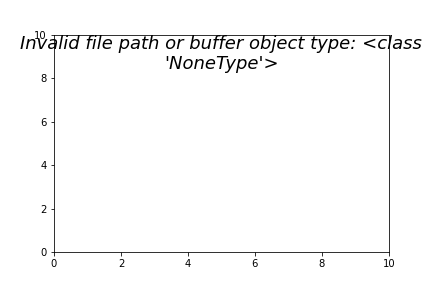
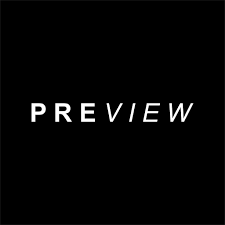

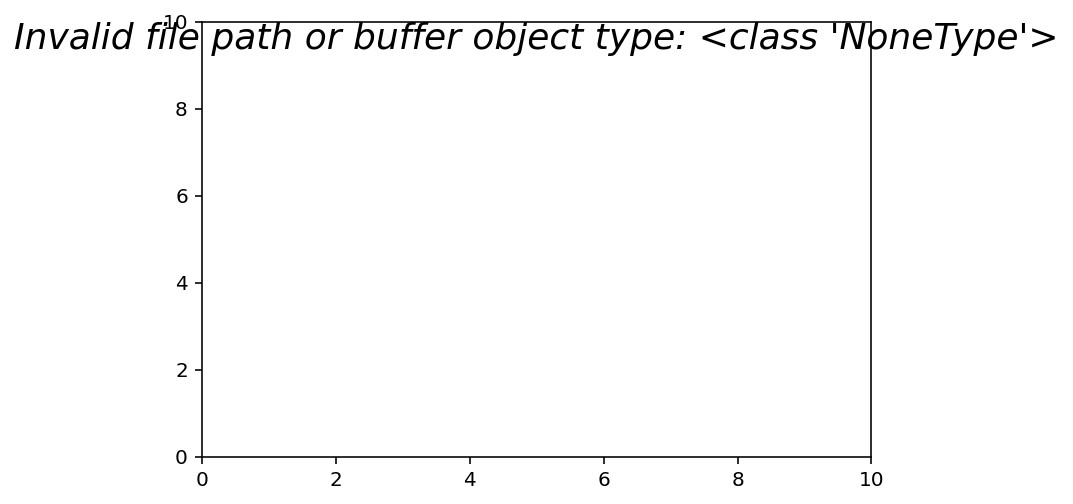

In [70]:
dashboard = pn.Column(
    pn.Column('Annotation file (.csv)', annotation_text),
    pn.Row(action_video.param.import_annotation),
    pn.Row(action_video.import_anno),
    pn.Row(multi_label_select, pn.Column(column_count, update_row, 
    # pn.Column(f"Inferred #rows", row_count)
    )),
    pn.Column(input_file, output_text),
    pn.Row('### Preview from video'),
    pn.Column(action_video.param.preview_button, action_video.render_preview),
    pn.Row('### Draw full video'),
    pn.Row(update_sampling_rate, sampling_rate),
    pn.panel(action_video.param.draw_video),
    # pn.panel(progress_bar),
    pn.panel(action_video.matrix_visualize)
)

# Launch the dashboard
dashboard.servable()


In [61]:
# fig, axes = plt.subplots(4, 1)
# img = np.random.randn(320, 640)
# plt.savefig('image.png', bbox_inches='tight',pad_inches = 0)
# plt.savefig('image_white.png')

Processing frame 0...


Column
    [0] Markdown(str)
    [1] PNG(str, height=1120, sizing_mode='fixed', width=960)
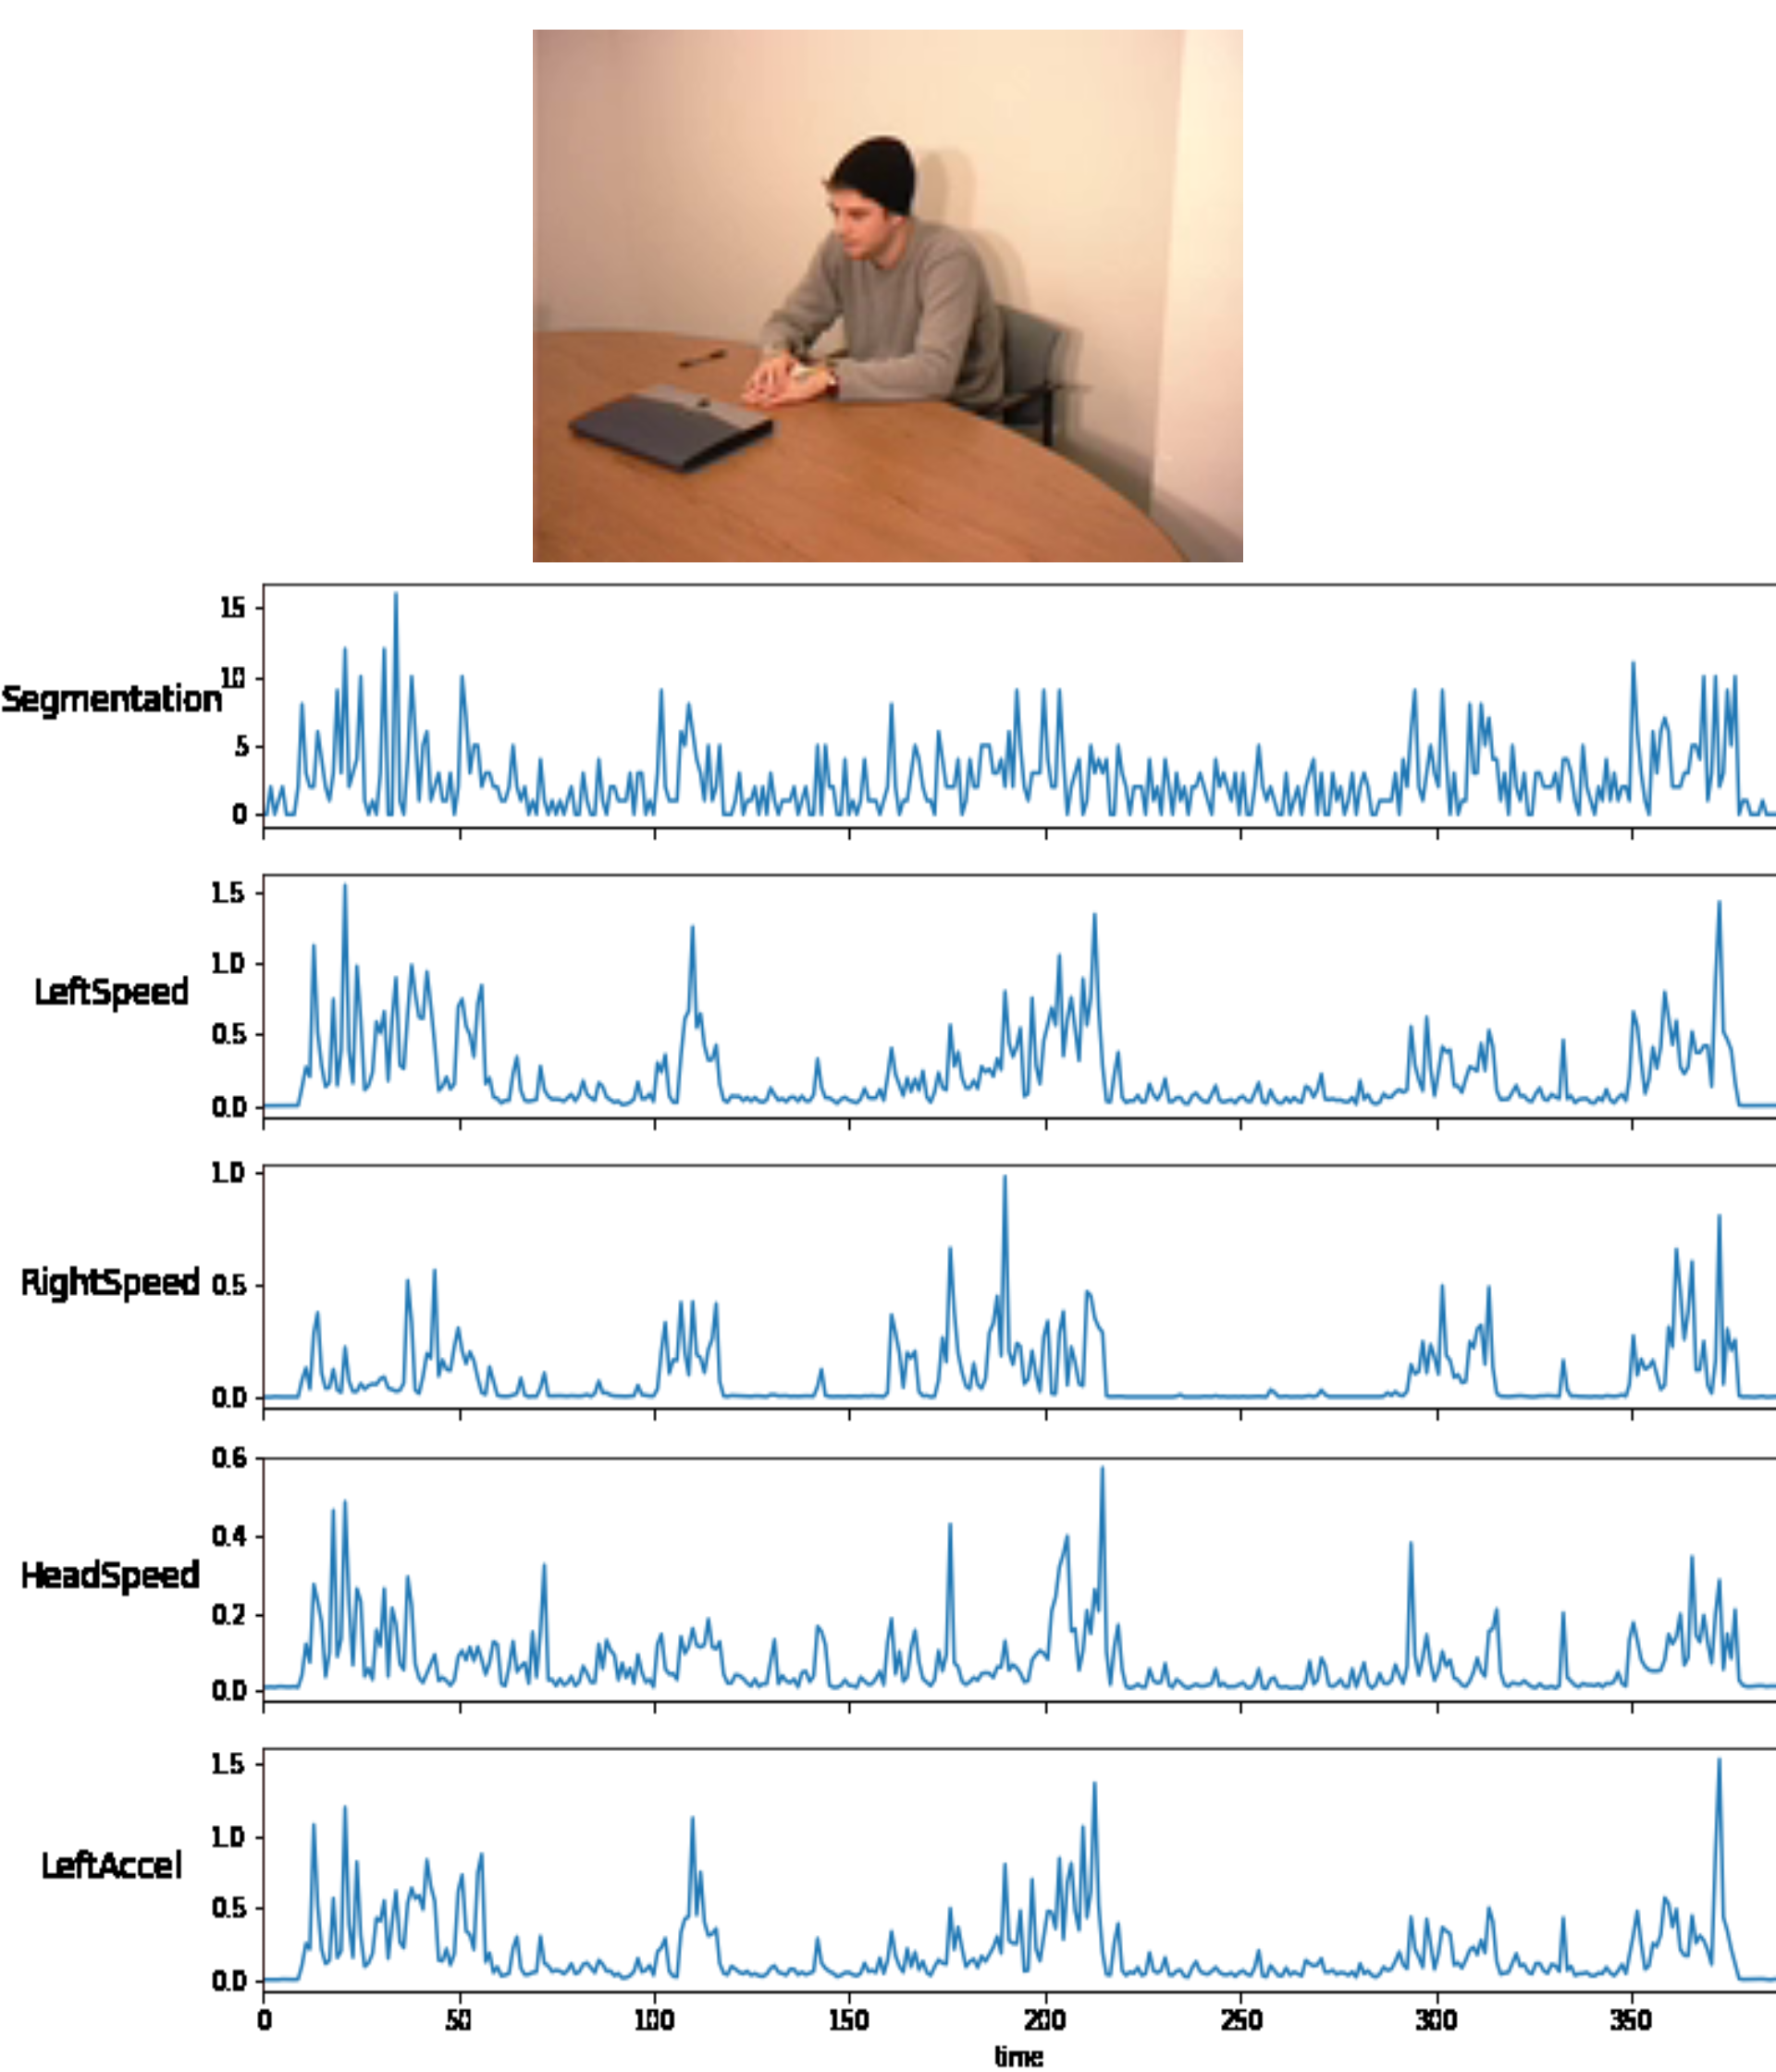

In [62]:
# annotation_text.filename = 'e51_bills.csv'
# action_video.import_anno()
# multi_label_select.value = multi_label_select.options[:5]
# column_count.value = 1
# action_video.render_preview()

In [12]:
# annotation_text.filename = 'e51_bills.csv'
# action_video.import_anno()
# multi_label_select.value = multi_label_select.options[:3]
# sampling_rate.value = 1
# column_count.value = 1
# action_video.matrix_visualize()

Processing frame 0...
Processing frame 10...
Processing frame 20...
Processing frame 30...
Processing frame 40...
Processing frame 50...
Processing frame 60...
Processing frame 70...
Processing frame 80...
Processing frame 90...
Processing frame 100...
Processing frame 110...
Processing frame 120...
Processing frame 130...
Processing frame 140...
Processing frame 150...
Processing frame 160...
Processing frame 170...
Processing frame 180...
Processing frame 190...
Processing frame 200...
Processing frame 210...
Processing frame 220...
Processing frame 230...
Processing frame 240...
Processing frame 250...
Processing frame 260...
Processing frame 270...
Processing frame 280...
Processing frame 290...
Processing frame 300...
Processing frame 310...
Processing frame 320...
Processing frame 330...
Processing frame 340...
Processing frame 350...
Processing frame 360...
Processing frame 370...
Processing frame 380...
Processing frame 390...
Processing frame 400...
Processing frame 410...
Pro

Row
    [0] Markdown(str)

In [14]:
# files = pn.widgets.FileSelector('.')
# files